In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import tarfile
import pandas as pd
import numpy as np
import igraph as ig
import torch
import numpy as np
import dgl
import tqdm
import sklearn.metrics

## Работа с данными

In [3]:
columns = [
            "public",
            "completion_percentage",
            "gender",
            "region",
            "last_login",
            "registration",
            "AGE",
            "body",
            "I_am_working_in_field",
            "spoken_languages",
            "hobbies",
            "I_most_enjoy_good_food",
            "pets",
            "body_type",
            "my_eyesight",
            "eye_color",
            "hair_color",
            "hair_type",
            "completed_level_of_education",
            "favourite_color",
            "relation_to_smoking",
            "relation_to_alcohol",
            "sign_in_zodiac",
            "on_pokec_i_am_looking_for",
            "love_is_for_me",
            "relation_to_casual_sex",
            "my_partner_should_be",
            "marital_status",
            "children",
            "relation_to_children",
            "I_like_movies",
            "I_like_watching_movie",
            "I_like_music",
            "I_mostly_like_listening_to_music",
            "the_idea_of_good_evening",
            "I_like_specialties_from_kitchen",
            "fun",
            "I_am_going_to_concerts",
            "my_active_sports",
            "my_passive_sports",
            "profession",
            "I_like_books",
            "life_style",
            "music",
            "cars",
            "politics",
            "relationships",
            "art_culture",
            "hobbies_interests",
            "science_technologies",
            "computers_internet",
            "education",
            "sport",
            "movies",
            "travelling",
            "health",
            "companies_brands",
            "more",
            ""
        ]

In [3]:
df_all = pd.read_csv('soc-pokec-profiles.txt.gz', compression='gzip', sep='\t', names=columns, encoding='utf-8', on_bad_lines='skip', index_col=None)

In [4]:
df_all.head()

,public,completion_percentage,gender,region,last_login,registration,AGE,body,I_am_working_in_field,spoken_languages,...,science_technologies,computers_internet,education,sport,movies,travelling,health,companies_brands,more,
1,1,14,1.0,"zilinsky kraj, zilina",2012-05-25 11:20:00.0,2005-04-03 00:00:00.0,26.0,"185 cm, 90 kg",it,anglicky,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,62,0.0,"zilinsky kraj, kysucke nove mesto",2012-05-25 23:08:00.0,2007-11-30 00:00:00.0,0.0,"166 cm, 58 kg",NaN,nemecky,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,1,64,1.0,"zilinsky kraj, kysucke nove mesto",2012-05-25 23:19:40.0,2008-05-18 00:00:00.0,23.0,"173 cm, 70 kg",najvatcsej firme na svete urad prace,no predsa svoj :d a najlepsie druhy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,38,1.0,"bratislavsky kraj, bratislava - karlova ves",2012-05-10 18:05:00.0,2010-05-23 00:00:00.0,29.0,NaN,"reklamy a medii, sluzieb a obchodu","anglicky, nemecky",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,12,0.0,"banskobystricky kraj, brezno",2011-12-29 12:25:00.0,2011-12-29 00:00:00.0,26.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Предобработка данных

In [5]:
from sklearn.preprocessing import LabelEncoder

Работа с профилями, в которых заполнен возраст

In [6]:
df_known = df_all.copy()
df_known = df_known[~df_known.AGE.isnull()]
df_known = df_known[df_known.AGE != 0]
df_known = df_known[df_known.AGE < 100]

In [7]:
edges = pd.read_csv('soc-pokec-relationships.txt.gz', compression='gzip', sep='\t', names=["from", "to"], encoding='utf-8', on_bad_lines='skip', index_col=False)

Индексы к 0...len

In [8]:
ids = list(df_known.index)
edges = edges[(edges['from'].isin(ids) & edges['to'].isin(ids))]

In [9]:
df_known.index = list(range(df_known.shape[0]))

In [10]:
transform_indexes = {}
for i in range(len(ids)):
    transform_indexes[ids[i]] = i

In [11]:
edges['from'] = edges['from'].apply(lambda x : transform_indexes[x])
edges['to'] = edges['to'].apply(lambda x : transform_indexes[x])

In [12]:
edges.head(5)

,from,to
1,0,19
2,0,9
3,0,2
4,0,3
5,0,5


Обработка признаков

In [15]:
df = df_known[["public", "completion_percentage", "gender", "region", "AGE", "last_login", "completed_level_of_education"]]

In [16]:
# регион
le = LabelEncoder()
df.loc[:, 'region'] = le.fit_transform(df['region'])
df.loc[:, 'region'] = df['region'].apply(lambda x : int(x))

In [17]:
import string
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

def get_words(text):
    res = text.translate(translator).split()
    #res = re.sub('['+string.punctuation+']', ' ', text).split()
    for i in range(0, len(res)):
        res[i] = res[i].strip()
    return res

In [18]:
import math
def transform(val, transformer):
    if val is None or val == " " or (type(val) is float and math.isnan(val)):
        return 0
    return transformer(val)
def relable_transformer(val, keywords, no_hit_to_null=True):
    if val == 0:
        return 0
    val_clean = ' '.join(get_words(val))
    for keyword, repl in keywords:
        if keyword in val_clean:
            return repl
    if no_hit_to_null:
        return 0
    else:
        return val

In [19]:
# ключевые слова в completed_level_of_education для сопоставления с уровнем образования
edu_keywords = [('stredoskolske', 1), ('zakladne', 1), # среднее и основное образование
                ('vysokoskolske', 2), # колледж
                ('ucnovske', 3), # стажировка
                ('studujem', 4), ('student', 3), # студент
                ('pracuje', 5), # практика
                ('bakalarske', 6)] # бакалавриат
df.loc[:, 'completed_level_of_education'] = df['completed_level_of_education'].apply(lambda x: transform(x, lambda v: relable_transformer(v, edu_keywords)))

In [20]:
# время последнего захода в сеть
import datetime
df.loc[:, "last_login"] = df["last_login"].apply(lambda x : int(datetime.datetime.strptime(x.split()[0],  '%Y-%m-%d').timestamp()))

In [21]:
from sklearn import preprocessing
df.loc[:, 'last_login'] = preprocessing.normalize([df['last_login']])[0]

In [22]:
# функция для обработки информации о теле (рост, вес)
import re
def transform_body(val):
    if val is None or (type(val) is float and math.isnan(val)):
        return 0, 0
    height_program = re.compile(r"[0-9]+(\s*)cm")
    weight_program = re.compile(r"[0-9]+(\s*)kg")
    h = re.search(height_program, val)
    if h is None:
        h = 0
    else:
        h = re.sub(r'(\s*)cm', '', h.group(0))
    w = re.search(weight_program, val)
    if w is None:
        w = 0
    else:
        w = re.sub(r'(\s*)kg', '', w.group(0))
    if int(h) > 10000:
        h = 0
    if int(w) > 10000:
        w = 0
    return int(h), int(w)

In [24]:
df.loc[:, "hight"] = df_known["body"].apply(lambda x : transform_body(x)[0])
df.loc[:, "weight"] = df_known["body"].apply(lambda x : transform_body(x)[1])

In [25]:
df = df.astype({'region': 'int64', 'completed_level_of_education': 'int64', 'hight' : 'int64', 'weight' : 'int64', 'last_login' : 'float64'})

In [93]:
df.to_csv("pokec-df-processed2.csv")

In [94]:
edges.to_csv("pokec-edges-processed2.csv")

In [26]:
# фичи и возраст
node_features = df.loc[:, df.columns != 'AGE'].values
node_labels = df.loc[:, df.columns == 'AGE'].values.flatten()
node_features = torch.FloatTensor(node_features)
node_labels = torch.LongTensor(node_labels)

In [27]:
num_features = node_features.shape[1]
num_classes = (node_labels.max() + 1).item()

In [28]:
graph = dgl.graph((edges.values[:, 0], edges.values[:, 1]))

In [99]:
# разделение на обучающую, валидационную и тестовую выборку
ind = df.index.values
np.random.shuffle(ind)
train_nids = ind[0:int(len(ind)*0.9)]
test_nids = ind[int(len(ind)*0.9):]

In [100]:
with open('train2.txt', 'w') as f:
    for line in train_nids:
        f.write(f"{line}\n")

In [101]:
with open('test2.txt', 'w') as f:
    for line in test_nids:
        f.write(f"{line}\n")

## GraphSAGE

In [30]:
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn

class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, 'mean'))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, 'mean'))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, 'mean'))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
            if l != self.n_layers - 1:
                x = F.relu(x)
        return x

In [36]:
model = SAGE(num_features, 9, num_classes, 2)
opt = torch.optim.Adam(model.parameters())

In [32]:
sampler = dgl.dataloading.MultiLayerNeighborSampler([7, 7])
train_dataloader = dgl.dataloading.DataLoader(
    graph, train_nids, sampler,
    batch_size=1024,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [34]:
best_model_path = 'GraphSAGE_model.pt'

100%|██████████| 1000/1000 [00:07<00:00, 137.39it/s, loss=3.759, mae=7.736]


Epoch 0 MAE 7.736111111111111


100%|██████████| 1000/1000 [00:07<00:00, 138.61it/s, loss=3.924, mae=7.569]


Epoch 1 MAE 7.569444444444445


100%|██████████| 1000/1000 [00:06<00:00, 144.76it/s, loss=3.521, mae=6.417]


Epoch 2 MAE 6.416666666666667


100%|██████████| 1000/1000 [00:07<00:00, 140.79it/s, loss=3.541, mae=7.361]


Epoch 3 MAE 7.361111111111111


100%|██████████| 1000/1000 [00:07<00:00, 131.47it/s, loss=3.515, mae=7.069]


Epoch 4 MAE 7.069444444444445


100%|██████████| 1000/1000 [00:07<00:00, 131.38it/s, loss=3.567, mae=7.194]


Epoch 5 MAE 7.194444444444445


100%|██████████| 1000/1000 [00:07<00:00, 140.46it/s, loss=3.623, mae=7.958]


Epoch 6 MAE 7.958333333333333


100%|██████████| 1000/1000 [00:06<00:00, 147.98it/s, loss=3.365, mae=6.319]


Epoch 7 MAE 6.319444444444445


100%|██████████| 1000/1000 [00:07<00:00, 135.31it/s, loss=3.409, mae=6.153]


Epoch 8 MAE 6.152777777777778


100%|██████████| 1000/1000 [00:07<00:00, 134.02it/s, loss=3.474, mae=6.792]


Epoch 9 MAE 6.791666666666667


100%|██████████| 1000/1000 [00:07<00:00, 140.62it/s, loss=3.203, mae=5.097]


Epoch 10 MAE 5.097222222222222


100%|██████████| 1000/1000 [00:07<00:00, 139.08it/s, loss=3.304, mae=5.444]


Epoch 11 MAE 5.444444444444445


100%|██████████| 1000/1000 [00:06<00:00, 146.01it/s, loss=3.414, mae=7.097]


Epoch 12 MAE 7.097222222222222


100%|██████████| 1000/1000 [00:07<00:00, 139.54it/s, loss=3.208, mae=5.778]


Epoch 13 MAE 5.777777777777778


100%|██████████| 1000/1000 [00:07<00:00, 139.34it/s, loss=3.156, mae=5.125]


Epoch 14 MAE 5.125


100%|██████████| 1000/1000 [00:06<00:00, 144.53it/s, loss=3.395, mae=6.208]


Epoch 15 MAE 6.208333333333333


100%|██████████| 1000/1000 [00:06<00:00, 145.66it/s, loss=3.405, mae=6.722]


Epoch 16 MAE 6.722222222222222


100%|██████████| 1000/1000 [00:07<00:00, 140.20it/s, loss=3.299, mae=5.764]


Epoch 17 MAE 5.763888888888889


100%|██████████| 1000/1000 [00:07<00:00, 137.87it/s, loss=3.275, mae=6.139]


Epoch 18 MAE 6.138888888888889


100%|██████████| 1000/1000 [00:07<00:00, 135.19it/s, loss=3.191, mae=5.542]


Epoch 19 MAE 5.541666666666667


100%|██████████| 1000/1000 [00:07<00:00, 136.13it/s, loss=3.237, mae=5.083]


Epoch 20 MAE 5.083333333333333


100%|██████████| 1000/1000 [00:07<00:00, 140.16it/s, loss=3.159, mae=5.500]


Epoch 21 MAE 5.5


100%|██████████| 1000/1000 [00:07<00:00, 141.95it/s, loss=3.367, mae=6.153]


Epoch 22 MAE 6.152777777777778


100%|██████████| 1000/1000 [00:06<00:00, 143.28it/s, loss=3.155, mae=4.806]


Epoch 23 MAE 4.805555555555555


100%|██████████| 1000/1000 [00:06<00:00, 144.16it/s, loss=3.070, mae=4.931]


Epoch 24 MAE 4.930555555555555


100%|██████████| 1000/1000 [00:07<00:00, 141.08it/s, loss=3.192, mae=5.431]


Epoch 25 MAE 5.430555555555555


100%|██████████| 1000/1000 [00:06<00:00, 145.65it/s, loss=3.222, mae=5.667]


Epoch 26 MAE 5.666666666666667


100%|██████████| 1000/1000 [00:07<00:00, 140.10it/s, loss=3.480, mae=6.556]


Epoch 27 MAE 6.555555555555555


100%|██████████| 1000/1000 [00:06<00:00, 146.13it/s, loss=3.188, mae=5.625]


Epoch 28 MAE 5.625


100%|██████████| 1000/1000 [00:06<00:00, 148.75it/s, loss=3.332, mae=6.569]


Epoch 29 MAE 6.569444444444445


100%|██████████| 1000/1000 [00:06<00:00, 150.20it/s, loss=3.210, mae=5.083]


Epoch 30 MAE 5.083333333333333


100%|██████████| 1000/1000 [00:06<00:00, 149.30it/s, loss=3.316, mae=5.681]


Epoch 31 MAE 5.680555555555555


100%|██████████| 1000/1000 [00:06<00:00, 158.75it/s, loss=3.316, mae=5.958]


Epoch 32 MAE 5.958333333333333


100%|██████████| 1000/1000 [00:06<00:00, 147.45it/s, loss=3.359, mae=7.236]


Epoch 33 MAE 7.236111111111111


100%|██████████| 1000/1000 [00:06<00:00, 146.54it/s, loss=3.219, mae=6.361]


Epoch 34 MAE 6.361111111111111


100%|██████████| 1000/1000 [00:06<00:00, 151.31it/s, loss=3.248, mae=5.736]


Epoch 35 MAE 5.736111111111111


100%|██████████| 1000/1000 [00:06<00:00, 150.86it/s, loss=3.271, mae=6.333]


Epoch 36 MAE 6.333333333333333


100%|██████████| 1000/1000 [00:06<00:00, 150.54it/s, loss=3.336, mae=6.194]


Epoch 37 MAE 6.194444444444445


100%|██████████| 1000/1000 [00:06<00:00, 149.15it/s, loss=2.930, mae=4.361]


Epoch 38 MAE 4.361111111111111


100%|██████████| 1000/1000 [00:06<00:00, 145.47it/s, loss=3.288, mae=6.042]


Epoch 39 MAE 6.041666666666667


100%|██████████| 1000/1000 [00:06<00:00, 148.34it/s, loss=3.201, mae=5.431]


Epoch 40 MAE 5.430555555555555


100%|██████████| 1000/1000 [00:06<00:00, 152.88it/s, loss=3.117, mae=5.250]


Epoch 41 MAE 5.25


100%|██████████| 1000/1000 [00:06<00:00, 147.51it/s, loss=3.220, mae=5.875]


Epoch 42 MAE 5.875


100%|██████████| 1000/1000 [00:06<00:00, 147.69it/s, loss=3.543, mae=8.236]


Epoch 43 MAE 8.23611111111111


100%|██████████| 1000/1000 [00:06<00:00, 148.69it/s, loss=3.150, mae=5.056]


Epoch 44 MAE 5.055555555555555


100%|██████████| 1000/1000 [00:06<00:00, 152.43it/s, loss=3.247, mae=5.264]


Epoch 45 MAE 5.263888888888889


100%|██████████| 1000/1000 [00:06<00:00, 150.78it/s, loss=2.967, mae=4.986]


Epoch 46 MAE 4.986111111111111


100%|██████████| 1000/1000 [00:06<00:00, 148.89it/s, loss=3.044, mae=4.306]


Epoch 47 MAE 4.305555555555555


100%|██████████| 1000/1000 [00:06<00:00, 150.15it/s, loss=3.115, mae=4.958]


Epoch 48 MAE 4.958333333333333


100%|██████████| 1000/1000 [00:06<00:00, 148.62it/s, loss=3.215, mae=6.139]


Epoch 49 MAE 6.138888888888889


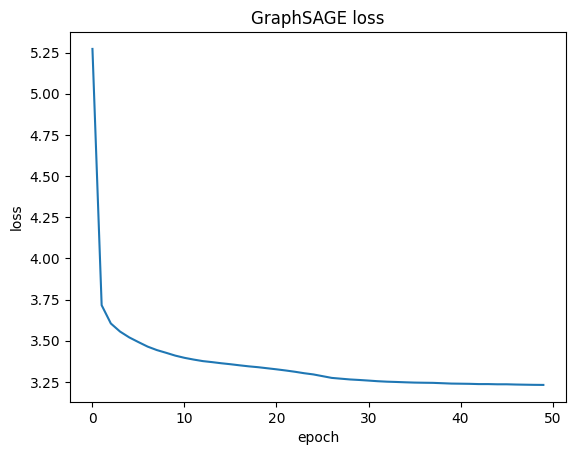

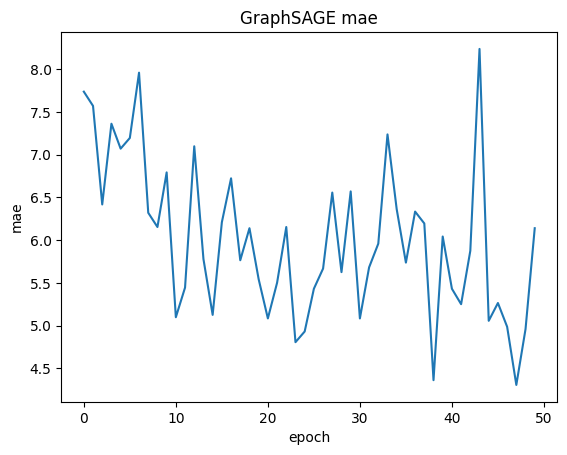

In [38]:
num_epochs = 50
best_mae = 10**10
train_loss = []
train_mae = []
for epoch in range(num_epochs):
    model.train()
    
    with tqdm.tqdm(train_dataloader) as tq:
        train_loss_list = []
        for step, (input_nodes, output_nodes, bipartites) in enumerate(tq):
            inputs = node_features[input_nodes]
            labels = node_labels[output_nodes]
            predictions = model(bipartites, inputs)

            loss = F.cross_entropy(predictions, labels)
            opt.zero_grad()
            loss.backward()
            opt.step()

            mae = sklearn.metrics.mean_absolute_error(labels.cpu().numpy(), predictions.argmax(1).detach().cpu().numpy())

            train_loss_list.append(loss.item())
            
            tq.set_postfix({'loss': '%.03f' % loss.item(), 'mae': '%.03f' % mae}, refresh=False)
    train_loss.append(np.mean(train_loss_list))
    train_mae.append(mae)
    print('Epoch {} MAE {}'.format(epoch, train_mae[-1]))
    if best_mae > train_mae[-1]:
        best_mae = train_mae[-1]
        torch.save(model.state_dict(), best_model_path)
    model.eval()
# plot loss
plt.plot(train_loss)
plt.title('GraphSAGE loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
# plot accuracy
plt.plot(train_mae)
plt.title('GraphSAGE mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show()

In [39]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    sampler = dgl.dataloading.MultiLayerFullNeighborSampler(1)
    dataloader = dgl.dataloading.DataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0]

                x = input_features[input_nodes]

                x = layer(bipartite, x)
                if l != model.n_layers - 1:
                    x = F.relu(x)

                output_features[output_nodes] = x.cpu()
            input_features = output_features
    return output_features

In [45]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [46]:
all_predictions = inference(model, graph, node_features, 8192)
test_predictions = all_predictions[test_nids].argmax(1)
test_labels = node_labels[test_nids]
test_mae = sklearn.metrics.mean_absolute_error(test_predictions.numpy(), test_labels.numpy())
print('Test MAE:', test_mae)

100%|██████████| 139/139 [00:01<00:00, 110.67it/s]

Test MAE: 5.778828559363784


In [47]:
result = pd.DataFrame([[int(x) for x in abs(test_predictions - test_labels)], [int(x) for x in test_predictions], [int(x) for x in test_labels]]).T
result.columns = ['abs', 'predict', 'test']

In [48]:
result.index = test_nids

In [49]:
result.sort_values("abs", ascending=False, inplace=True)

In [50]:
result["in_degree"] = list(result.index.map(lambda x : graph.in_degrees(x)))
result["out_degree"] = list(result.index.map(lambda x : graph.out_degrees(x)))

In [51]:
result.head(50)

,abs,predict,test,in_degree,out_degree
661585,81,18,99,1,0
368120,81,16,97,2,4
1064525,81,18,99,1,0
417129,81,18,99,23,39
631102,81,18,99,7,15
156447,80,18,98,3,3
145205,80,18,98,18,19
717906,78,19,97,1,0
601393,77,20,97,4,9
1044916,76,16,92,2,2


In [57]:
result[result["test"] < 60].head(20)

,abs,predict,test,in_degree,out_degree
606859,52,63,11,4,3
1127909,49,68,19,1,1
1051732,45,14,59,0,1
1109713,45,14,59,0,1
709888,45,14,59,1,0
1126203,43,16,59,0,0
1067327,43,16,59,1,0
857385,43,12,55,1,1
855842,43,16,59,1,1
1109555,43,16,59,0,1
